In [154]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [155]:
tf.__version__

'2.0.0-alpha0'

## Basic TensorFlow usage

In [156]:
a = tf.constant([1, 2])
b = tf.constant([3, 4])
print(a + b)

tf.Tensor([4 6], shape=(2,), dtype=int32)


In [157]:
# convinience function to read EMNIST data into numpy array
def read_mnist(images_path, labels_path):
    with open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28)
        features = features.astype(float)
        flip = features[:,:, ::-1,...]       # note that images are flipped
        features = np.rot90(flip, 1, (1,2))  # and rotated 90deg
        
    return features, labels

## Load Data
Test and training data and labels need to be read from the binary files and converted into a form for easy use. Luckily, this data is small enough to fit in memory.
This data set has some pecularities, like images are flipped and rotated 90%. This needs to be accounts for as well.

In [158]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('data/emnist-bymerge-train-images-idx3-ubyte', 'data/emnist-bymerge-train-labels-idx1-ubyte')
test['features'], test['labels'] = read_mnist('data/emnist-bymerge-test-images-idx3-ubyte', 'data/emnist-bymerge-test-labels-idx1-ubyte')

In [159]:
# Lets read the labels so that directories can be named appropriately
def map_labels(label_mappings="data/emnist-bymerge-mapping.txt"):
    labels_dict = {}
    with open(label_mappings, 'rb') as f:
        # each row of the file has the label first and ascii code next
        for line in f:
            items = line.split()
            # note that data is in bytes, so need to convert
            labels_dict.update({int(items[0]): chr(int(items[1]))})
    return labels_dict

# convenience function to display a grid of random images
def display_images(features, labels, mapping):
    # Now, lets try and generate some sample images to see what the data looks like
    fig=plt.figure(figsize=(9, 9))  # show 8in X 8in image
    columns = 4  # 4 images per row
    rows = 5  # lay out images on 5 rows
    for i in range(1, columns*rows +1):
        img_id = np.random.randint(0, features.shape[0])  # max number of images, from prev section
        fig.add_subplot(rows, columns, i)
        img_data = features[img_id].squeeze()  #,:,:]
        plt.title('Label: %d Char: %s' % ( labels[img_id], mapping[labels[img_id]]))
        plt.imshow(img_data, cmap='gray')
    plt.subplots_adjust(hspace=0.5)
    plt.show()


## Visualize Data
It is always useful to plot a few samples of the data, especially for visual applications, to build intuition and ensure things are as expected.

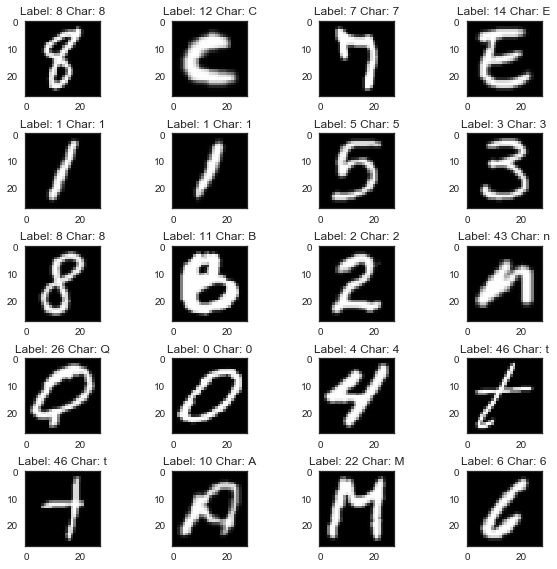

In [160]:
labels = map_labels()
display_images(train['features'], train['labels'], labels)

## Our First Model
Keras makes it really easy to specify model architectures at a high level. In TensorFlow 2.0, further simplfications have been made, so that the code is really clean and simple to follow. In the chapter, the model architecture was specified to have 256 units in first hidden layer, 128 in the second one. The hidden layers had ReLU as the activation function and the output layer had softmax.

In [161]:
model = tf.keras.Sequential(name='First FC DL Model')
# flatten from a 28px X 28px into 784 inputs.
model.add(layers.Flatten(input_shape=(28, 28)))
# Adds a densely-connected layer with 64 units to the model:
model.add(layers.Dense(256, activation='relu'))
# Add another:
model.add(layers.Dense(128, activation='relu'))
# Add a softmax layer with 47 output units:
model.add(layers.Dense(47, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

norm_train_features = keras.utils.normalize(train['features'])
norm_test_features = keras.utils.normalize(test['features'])

In [162]:
# useful to check, especially for complex models
model.summary()

Model: "First FC DL Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_37 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_38 (Dense)             (None, 47)                6063      
Total params: 239,919
Trainable params: 239,919
Non-trainable params: 0
_________________________________________________________________


In [163]:
# Simple straightforward training
one_hot_labels = tf.one_hot(train['labels'], 47)
model.fit(train['features'], one_hot_labels, epochs=10, batch_size=128)

Epoch 1/10
697932/697932 [==============================] - 51s 73us/sample - loss: 1.3555 - accuracy: 0.6810
Epoch 2/10
697932/697932 [==============================] - 54s 77us/sample - loss: 0.5639 - accuracy: 0.8187
Epoch 3/10
697932/697932 [==============================] - 46s 67us/sample - loss: 0.5142 - accuracy: 0.8330
Epoch 4/10
697932/697932 [==============================] - 34s 48us/sample - loss: 0.4935 - accuracy: 0.8398
Epoch 5/10
697932/697932 [==============================] - 27s 39us/sample - loss: 0.4818 - accuracy: 0.8436
Epoch 6/10
697932/697932 [==============================] - 28s 40us/sample - loss: 0.4737 - accuracy: 0.8453
Epoch 7/10
697932/697932 [==============================] - 28s 41us/sample - loss: 0.4662 - accuracy: 0.8476
Epoch 8/10
697932/697932 [==============================] - 27s 39us/sample - loss: 0.4623 - accuracy: 0.8495
Epoch 9/10
697932/697932 [==============================] - 32s 46us/sample - loss: 0.4586 - accuracy: 0.8496
Epoch 10/1

In [164]:
# and evaluation against the test set
model.evaluate(test['features'], tf.one_hot(test['labels'], 47))

116323/116323 [==============================] - 8s 65us/sample - loss: 0.5018 - accuracy: 0.8437


[0.5017663449975875, 0.84366804]

In [165]:
# Training with normalization of inputs
model.fit(norm_train_features, one_hot_labels, epochs=10, batch_size=128)  # includes a step of data normalization

Epoch 1/10
697932/697932 [==============================] - 54s 77us/sample - loss: 0.5658 - accuracy: 0.8189
Epoch 2/10
697932/697932 [==============================] - 36s 51us/sample - loss: 0.3741 - accuracy: 0.8685
Epoch 3/10
697932/697932 [==============================] - 28s 40us/sample - loss: 0.3487 - accuracy: 0.8756
Epoch 4/10
697932/697932 [==============================] - 27s 39us/sample - loss: 0.3332 - accuracy: 0.8801
Epoch 5/10
697932/697932 [==============================] - 26s 38us/sample - loss: 0.3218 - accuracy: 0.8832
Epoch 6/10
697932/697932 [==============================] - 25s 36us/sample - loss: 0.3130 - accuracy: 0.8853
Epoch 7/10
697932/697932 [==============================] - 26s 38us/sample - loss: 0.3062 - accuracy: 0.8872
Epoch 8/10
697932/697932 [==============================] - 28s 40us/sample - loss: 0.3001 - accuracy: 0.8893
Epoch 9/10
697932/697932 [==============================] - 31s 44us/sample - loss: 0.2950 - accuracy: 0.8905
Epoch 10/1

In [166]:
# and evaluation
model.evaluate(norm_test_features, tf.one_hot(test['labels'], 47))

116323/116323 [==============================] - 8s 70us/sample - loss: 0.3545 - accuracy: 0.8765


[0.3545085270509427, 0.87650764]